In [62]:
%matplotlib inline

import lsst.daf.persistence as dafPersist
import lsst.afw.image as afwImage
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.coord as afwCoord
from lsst.meas.astrom.loadAstrometryNetObjects import LoadAstrometryNetObjectsTask
import lsst.meas.astrom as measAstrom
import lsst.meas.algorithms as measAlg

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 6.5)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelcolor'] = "#000000"
np.seterr(invalid="ignore")

{'divide': 'warn', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [12]:
#b_branch = dafPersist.Butler("Cfht/output")
#b_branch = dafPersist.Butler("/ssd/rowen/lsstsw/build/validate_drp/cfht_saved/dm4692_2017-02-18")

b_master = dafPersist.Butler("../validate_drp_master/Cfht/output")

adn_config = LoadAstrometryNetObjectsTask.ConfigClass()
refObjLoader = LoadAstrometryNetObjectsTask(adn_config)

In [6]:
fitTanSipConfig = measAstrom.fitTanSipWcs.FitTanSipWcsConfig()

fitTanSip = measAstrom.FitTanSipWcsTask(fitTanSipConfig)

In [69]:
class SrcRefDatasets:
    def __init__(self, butler, visit, ccd, refObjLoader, match_dtype="srcMatch", src_dtype="src"):
        self.butler = butler
        self.src = butler.get(src_dtype, visit=visit, ccd=ccd, immediate=True)
        self.exposure = butler.get('calexp',  visit=visit, ccd=ccd, immediate=True)
        self.calexp_md = butler.get('calexp_md',  visit=visit, ccd=ccd, immediate=True)

        self.matches_catalog = butler.get(match_dtype, visit=visit, ccd=ccd, immediate=True)
        self.matches =  refObjLoader.joinMatchListWithCatalog(self.matches_catalog, self.src)
        
        self.calib = afwImage.Calib(self.calexp_md)
        self.bbox = self.exposure.getBBox()
        loadRes = refObjLoader.loadPixelBox(
            bbox = self.bbox,
            wcs = self.exposure.getWcs(),
            filterName = 'r',
            calib = self.calib)
        self.refCat = loadRes.refCat
        self.reference_ids = np.array([source.getId() for source in self.refCat])


In [107]:
ccdnum = 20
visit = 849375
src_ref = SrcRefDatasets(b_master, visit, ccdnum, refObjLoader, match_dtype="icMatch", src_dtype="icSrc")

initWcs = src_ref.exposure.getWcs()


fitStruct = fitTanSip.fitWcs(src_ref.matches, initWcs, bbox=src_ref.bbox, refCat=src_ref.refCat, sourceCat=src_ref.src)
print "Scatter: {:.2f} mas".format(fitStruct.scatterOnSky.asArcseconds()*1000.0)
original_scatter_mas = fitStruct.scatterOnSky.asArcseconds()*1000.0


Scatter: 31.11 mas


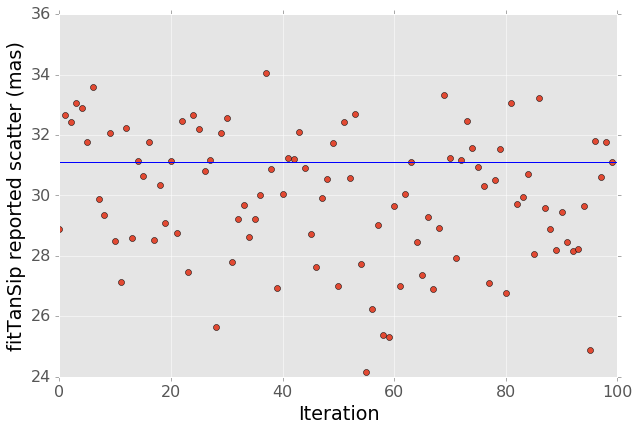

In [136]:
scatter_vals = []
for iter_n in xrange(100):
    n_matches = len(src_ref.matches)
    n_omitted = 3
    match_sel_list = set(np.arange(n_matches)) - set(np.random.randint(0,n_matches, n_omitted))
    new_matches = [src_ref.matches[x] for x in match_sel_list]

    fitStruct = fitTanSip.fitWcs(new_matches, initWcs, bbox=src_ref.bbox,
                                 refCat=src_ref.refCat, sourceCat=src_ref.src)
    scatter_mas = fitStruct.scatterOnSky.asArcseconds()*1000.0
    scatter_vals.append(scatter_mas)
    #print "Scatter: {:.2f} mas".format(scatter_mas)

plt.plot(scatter_vals, 'o')
plt.axhline(original_scatter_mas)
plt.ylabel("fitTanSip reported scatter (mas)")
plt.xlabel("Iteration")

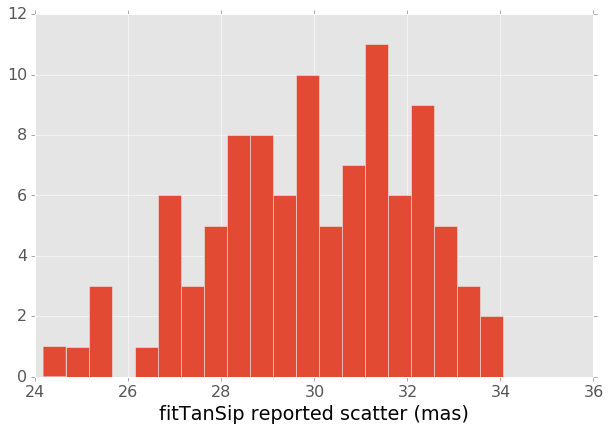

In [140]:
_ = plt.hist(scatter_vals, bins=20)
plt.xlabel("fitTanSip reported scatter (mas)")